![CTA first data challenge logo](images/cta-1dc.png)

# CTA first data challenge (1DC) with Gammapy


## Introduction

The [CTA observatory](https://www.cta-observatory.org/) has started a first data challenge ("CTA 1DC"), focusing on high-level data analysis. Gammapy is a prototype for the CTA science tools (see [Gammapy proceeding from ICRC 2017](https://github.com/gammapy/icrc2017-gammapy-poster/blob/master/proceeding/gammapy-icrc2017.pdf)), and while many things are work in progress (most importantly: source and background modeling and cube analysis), you can use it already to analyse the simulated CTA data.

The main page for CTA 1DC is here:
https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki (CTA internal)

There you will find information on 1DC sky models, data access, data organisation, simulation and analysis tools, simulated observations, as well as contact information if you have any questions or comments.

### This tutorial notebook

This notebook shows you how to get started with CTA 1DC data and what it contains.

You will learn how to use Astropy and Gammapy to:

* access event data
* access instrument response functions (IRFs)
* use index files and the ``gammapy.data.DataStore`` to access all data
* use the observation index file to select the observations you're interested in
* read model XML files from Python (not integrated in Gammapy yet)

This is to familiarise ourselves with the data files and to get an overview.

### Further information

How to analyse the CTA 1DC data with Gammapy (make an image and spectrum) is shown in a second notebook [cta_data_analysis.ipynb](cta_data_analysis.ipynb). If you prefer, you can of course just skim or skip this notebook and go straight to second one.

More tutorial notebooks for Gammapy are [here](../index.ipynb),
the Gammapy Sphinx docs are at at http://docs.gammapy.org
If you have a Gammapy-related question, please send an email to to Gammapy mailing list at http://groups.google.com/group/gammapy (registration required) or if you have an issue or feature request, file an issue here: https://github.com/gammapy/gammapy/issues/new (free Github account required, takes 1 min to set up).

Please note that the 1DC data isn't public and results should be shared on CTA Redmine, as described here: https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki#Sharing-of-analysis-results. Unfortunately there's no good way yet to share Jupyter notebooks in CTA, as there is e.g. on Github and nbviewer which can show any public noteook.

## Notebook and Gammapy Setup

Before we get started, please execcute the following code cells.

The first one configures the notebooks so that plots are shown inline (if you don't do this, separate windows will pop up). The second cell imports and checks the version of the packages we will use below. If you're missing some packages, install them and then select "Kernel -> Restart" above to restart this notebook.

In case you're new to Jupyter notebooks: to execute a cell, select it, then type "SHIFT" + "ENTER".

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
import gammapy

print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('gammapy:', gammapy.__version__)

numpy: 1.13.1
astropy: 3.0.dev19958
gammapy: 0.7.dev5068


## Getting the 1DC data

You can find infos how to download the 1DC data here: 
https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki#Data-access

Overall it's quite large (20 GB) and will take a while to download. You can just download a subset of the "gps", "gc", "egal" or "agn" datasets, the ones you're interested in. In this tutorial, we will only use the "gc" (Galactic center) dataset, so maybe you could start by downloading that first.

While you wait, we strongly recommend you go over some [CTA basics](https://www.youtube.com/playlist?list=PLq3ItKoU0hy7ED6m1eve6WIFs7ibcv3YR) as well as some [Python basics](https://www.youtube.com/playlist?list=PL-Qryc-SVnnu0tPV623TFnrAEQLykkZF5) to prepare yourself for this tutorial.

Got the data?

Assuming you've followed the instructions, you should have the ``CTADATA`` environment variable pointing to the folder where all data is located. (Gammapy doesn't need or use the ``CALDB`` environment variable.)


In [3]:
!echo $CTADATA

/Users/deil/work/cta-dc/data/1dc/1dc


In [4]:
!ls $CTADATA

caldb  data   index  models obs


You can find a description of the directories and files here:
https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki/Data_organisation

A very detailed specification of the data formats is here:
http://gamma-astro-data-formats.readthedocs.io/

But actually, instead of reading those pages, let's just explore the data and see how to load it with Gammapy ...

Before we start, just in case the commands above show that you don't have `CTADATA` set:
* you either have to exit the "jupyter notebook" command on your terminal, set the environment variable (I'm using bash and added the command `export CTADATA=/Users/deil/work/cta-dc/data/1dc/1dc` to my `~/.profile` file and then did `source ~/.profile`), then re-start Jupyter and this notebook.
* or you can set the environment variable by uncommentting the code in the following cell, setting the correct path, then executing it.

In [5]:
# import os
# os.environ['CTADATA'] = '/Users/deil/work/cta-dc/data/1dc/1dc'
# !echo $CTADATA
# !ls $CTADATA

## Overview of 1DC data files

Let's have a look around at the directories and files in `$CTADATA`.

We will look at the `data` folder with events, the `caldb` folder with the IRFs and the `index` folder with the index files. At the end, we will also mention what the `model` and `obs` folder contains, but they aren't used with Gammapy, at least not at the moment.

### EVENT data

First, the EVENT data (RA, DEC, ENERGY, TIME of each photon or hadronic background event) is in the `data/baseline` folder, with one observation per file. The "baseline" refers to the assumed CTA array that was used to simulate the observations. The number in the filename is the observation identifier `OBS_ID` of the observation. Observations are ~ 30 minutes, pointing at a fixed location on the sky.

In [6]:
!ls $CTADATA

caldb  data   index  models obs


In [7]:
!ls $CTADATA/data/baseline

agn  egal gc   gps


In [8]:
!ls $CTADATA/data/baseline/gc | head -n3

gc_baseline_310000.fits
gc_baseline_310001.fits
gc_baseline_310002.fits


In [9]:
# There's 1671 observations and 5.9 GB of event data for the Galactic center "gc" survey
!ls $CTADATA/data/baseline/gc | wc -l
!du -hs $CTADATA/data/baseline/gc

    1671
5.9G	/Users/deil/work/cta-dc/data/1dc/1dc/data/baseline/gc


Let's open up the first event list using the Gammapy `EventList` class, which contains the ``EVENTS`` table data via the ``table`` attribute as an Astropy `Table` object.

In [10]:
from gammapy.data import EventList
events = EventList.read('$CTADATA/data/baseline/gc/gc_baseline_310000.fits')
print(type(events))
print(type(events.table))

<class 'gammapy.data.event_list.EventList'>
<class 'astropy.table.table.Table'>


In [11]:
# First event (using [] for "indexing")
events.table[0]

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,662774401.496,-94.4147,-30.1971,0.0338345,0.10751,-1.04139,2


In [12]:
# First few events (using [] for "slicing")
events.table[:2]

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,662774401.496,-94.4147,-30.1971,0.0338345,0.10751,-1.04139,2
2,662774405.43,-92.982,-28.3259,0.0540774,1.98403,0.200576,2


In [14]:
# Event times can be accessed as Astropy Time objects
print(type(events.time))

<class 'astropy.time.core.Time'>


In [15]:
events.time[:2]

<Time object: scale='tt' format='mjd' value=[ 59215.50001731  59215.50006284]>

In [16]:
# Convert event time to more human-readable format
print(events.time[:2].fits)

['2021-01-01T12:00:01.496(TT)' '2021-01-01T12:00:05.430(TT)']


In [17]:
# Event positions can be accessed as Astropy SkyCoord objects
print(type(events.radec))
events.radec[:2]

<class 'astropy.coordinates.sky_coordinate.SkyCoord'>


<SkyCoord (ICRS): (ra, dec) in deg
    [( 265.58529663, -30.19706917), ( 267.01800537, -28.32586861)]>

In [18]:
events.galactic[:2]

<SkyCoord (Galactic): (l, b) in deg
    [( 358.55250415, -0.05350589), (   0.80089378, -0.14331195)]>

In [19]:
# The event header information is stored
# in the `events.table.meta` dictionary
print(type(events.table.meta))
# E.g. to get the observation pointing position in degree:
events.table.meta['RA_PNT'], events.table.meta['DEC_PNT']

<class 'collections.OrderedDict'>


(266.79019165, -30.3101)

### EVENT analysis example

As an example how to work with EVENT data, let's look at the spatial and energy distribution of the events for a single run.

Note that EVENT data in Gammapy is just stored in an Astropy Table, which is basically a dictionary mapping column names to column data, where the column data is a Numpy array. This means you can efficienly process it from Python using any of the scientific Python tools you like (e.g. Numpy, Scipy, scikit-image, scikit-learn, ...)

#### EVENT spatial distribution

To illustrate a bit how to work with EVENT table an header data,
let's plot the event positions as well as the pointing position.

<SkyCoord (Galactic): (l, b) in deg
    ( 359.00001833, -0.99995901)>

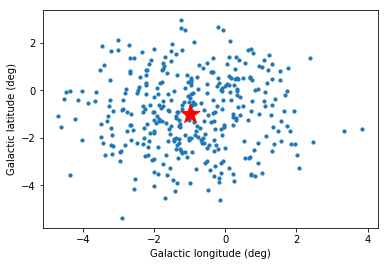

In [20]:
# Event positions
pos = events.galactic[::300] # sub-sample every 100th event
plt.scatter(pos.l.wrap_at('180 deg').deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(pos_pnt.l.wrap_at('180 deg').deg, pos_pnt.b.deg,
            marker='*', s=400, c='red')
plt.xlabel('Galactic longitude (deg)')
plt.ylabel('Galactic latitude (deg)')
pos_pnt

#### EVENT energy distribution

Let's have a look at the event energy distribution.

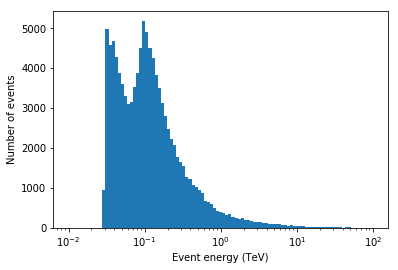

In [21]:
energy = events.table['ENERGY'].data
energy_bins = np.logspace(-2, 2, num=100)
plt.hist(energy, bins=energy_bins)
plt.semilogx()
plt.xlabel('Event energy (TeV)')
plt.ylabel('Number of events')

A double-peak, at ~ 30 GeV and ~ 100 GeV? .... let's try to find out what's going on ...

#### EVENT MC_ID

One idea could be to split the data into gamma-ray and hadronic background events.
Now from looking at the FITS header, one can see that ``MC_ID == 1`` is the hadronic background, and the other values are for different gamma-ray emission components.

In [22]:
is_gamma = events.table['MC_ID'] != 1
print('Number of events: ', len(events.table))
print('Number of gammas: ', is_gamma.sum())
print('Number of hadrons: ', len(events.table) - is_gamma.sum())

Number of events:  106710
Number of gammas:  8650
Number of hadrons:  98060


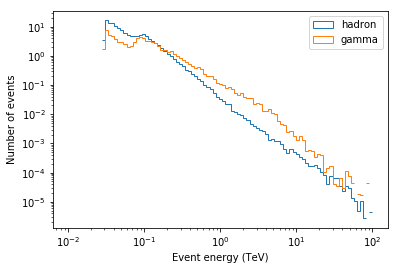

In [23]:
energy = events.table['ENERGY'].data
energy_bins = np.logspace(-2, 2, num=100)
opts = dict(bins=energy_bins, normed=True, histtype='step')
plt.hist(energy[~is_gamma], label='hadron', **opts)
plt.hist(energy[is_gamma], label='gamma', **opts)
plt.loglog()
plt.xlabel('Event energy (TeV)')
plt.ylabel('Number of events')
plt.legend()

As you can see, Gammapy is very flexible and powerful.
It even supports gamma-hadron separation for CTA!

As expected, the energy spectra are roughly power-laws. 
When plotting in log-log, one can see that the spectra are roughly power-laws (as expected), and the "double peak" we saw before looks more like a "double energy threshold" pattern.
It's there for gammas and background, and below 100 GeV the signal to background ratio is lower.

What we're seeing here is the result of a mixed-array in CTA with LSTs, MSTs and SSTs, which  have different energy thresholds:
* ~ 30 GeV is the energy threshold of the LSTs
* ~ 100 GeV is the energy threshold of the MSTs
* the energy threshold of the SSTs is at a few TeV and doesn't show up as a clear feature in the gamma and background energy distribution (probably the rise in slope in gamma in the 1-10 TeV range is due to the SSTs).

Let's look a little deeper and also check the event offset distribution in the field of view ...

#### EVENT FOV offset

The event position and offset in the field of view (FOV) can be computed from the event RA, DEC position and the observation pointing RA, DEC position.

But actually, the field of view position is stored as extra columns in the EVENT list: ``DETX`` and ``DETY`` (angles in degree, I think RA / DEC aligned field of view system).

I presume (hope) this unnecessary information will be dropped from the CTA event lists in the future to save some space (make the CTA DL3 data ~25% smaller), but for now, let's use those columns to compute the field of view offset and look at the offset-energy distribution of the events.

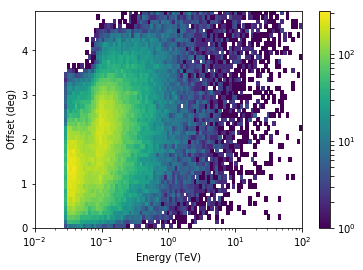

In [24]:
energy_bins = 10 ** np.linspace(-2, 2, 100)
offset_bins = np.arange(0, 5, 0.1)

t = events.table
offset = np.sqrt(t['DETX'] ** 2 + t['DETY'] ** 2)
hist = np.histogram2d(
    x=t['ENERGY'], y=offset,
    bins=(energy_bins, offset_bins),
)[0].T

from matplotlib.colors import LogNorm
plt.pcolormesh(energy_bins, offset_bins,
               hist, norm=LogNorm())
plt.semilogx()
plt.colorbar()
plt.xlabel('Energy (TeV)')
plt.ylabel('Offset (deg)')

So the CTA field of view increases with energy in steps. The energy distribution we saw before was the combination of the energy distribution at all offsets. Even at a single offset, the double energy-threshold at ~ 30 GeV and ~ 100 GeV is present.

#### Stacking EVENTS tables

As a final example of how to work with event lists, here's now to apply arbitrary event selections and how to stack events tables from several observations into a single event list. 

We will just use `astropy.table.Table` directly, not go via the `gammapy.data.EventList` class. Note that you can always make an `EventList` object from a `Table` object via `event_list = EventList(table)`. One point to keep in mind is that `Table.read` doesn't resolve environment variables in filenames, so we'll use the Python standard library `os` package to construct the filenames.

In [25]:
import os
from astropy.table import Table
from astropy.table import vstack as table_vstack

filename = os.path.join(os.environ['CTADATA'], 'data/baseline/gc/gc_baseline_310000.fits')
t1 = Table.read(filename, hdu='EVENTS')

filename = os.path.join(os.environ['CTADATA'], 'data/baseline/gc/gc_baseline_310001.fits')
t2 = Table.read(filename, hdu='EVENTS')
tables = [t1, t2]
table = table_vstack(tables, metadata_conflicts='silent')

In [26]:
print('Number of events: ', len(table))

Number of events:  213907


In [27]:
# Let's select gamma rays with energy above 10 TeV
mask_mc_id = table['MC_ID'] != 1
mask_energy = table['ENERGY'] > 10
mask = mask_mc_id & mask_energy
table2 = table[mask]
print('Number of events after selection:', len(table2))

Number of events after selection: 225


When processing a lot or all of the 1DC events, you would write a for loop, and apply the event selection before putting the table in the list of tables, or you might run out of memory. An example is [here](https://github.com/gammasky/cta-dc/blob/master/data/cta_1dc_make_allsky_images.py).

That's all for ``EVENTS``. You now know what every column in the event table contains, and how to work with event list tables using ``gammapy.data.EventList`` and ``astropy.table.Table``. 

Just in case that there is some observation parameter in the FITS EVENTS header that you're interested in, you can find the full description of the keys you can access via the ``events.table.meta`` dictionary [here](http://gamma-astro-data-formats.readthedocs.io/en/latest/events/events.html).

## Instrument response functions (IRFs)

The CTA instrument reponse functions are given as FITS files in the `caldb` folder.

Note that this is not realistic. Real CTA data at the DL3 level (what we have here, what users get) will mostly likely have per-observation or per-time interval IRFs, and the IRFs will not be stored in a separate CALDB folder, but distributed with the EVENTS (probably in the same file, or at least in the same folder, so that it's together.

The EVENT to IRF association can be done from 

In [69]:
!(cd $CTADATA && find caldb)

caldb
caldb/data
caldb/data/cta
caldb/data/cta/1dc
caldb/data/cta/1dc/bcf
caldb/data/cta/1dc/bcf/North_z20_50h
caldb/data/cta/1dc/bcf/North_z20_50h/irf_file.fits
caldb/data/cta/1dc/bcf/North_z40_50h
caldb/data/cta/1dc/bcf/North_z40_50h/irf_file.fits
caldb/data/cta/1dc/bcf/South_z20_50h
caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits
caldb/data/cta/1dc/bcf/South_z40_50h
caldb/data/cta/1dc/bcf/South_z40_50h/irf_file.fits
caldb/data/cta/1dc/caldb.indx


In [70]:
pwd

'/Users/deil/code/gammapy-extra/notebooks'

## Index files

bla

In [22]:
import os
data_store = DataStore.from_dir(CTADATA)
data_store.info()

NameError: name 'DataStore' is not defined

In [ ]:
print(data_store.obs_table.colnames)
obs_colnames = ['OBS_ID', 'DATE_OBS', 'TIME_OBS', 'GLON_PNT', 'GLAT_PNT']
data_store.obs_table[::100][obs_colnames]

## Select observations

To have something small and quick to play around with, let's just select three runs.

Since we'll use the reflected regions background estimation method below to compute a spectrum,
we'll select runs at a good distance to the target (the Galactic center source).

In [ ]:
def select_obs():
    t = data_store.obs_table.copy()
    pos_run = SkyCoord(t['GLON_PNT'], t['GLAT_PNT'], unit='deg', frame='galactic')
    pos_target = SkyCoord(0, 0, unit='deg', frame='galactic')
    d = pos_target.separation(pos_run).degree
    mask = (0 <= d) & (1 < d)
    return list(t[mask]['OBS_ID'])

obs_ids = select_obs()[:3]
print(obs_ids)
obs_list = data_store.obs_list(obs_ids)

In [ ]:
data_store.obs_table.select_obs_id(obs_ids)[obs_colnames]

In [ ]:
obs = obs_list[0]

In [ ]:
print(obs)

In [ ]:
obs.events.peek()

In [ ]:
obs.aeff.peek()

In [ ]:
obs.edisp.peek()

In [72]:
obs.psf.peek()

NameError: name 'obs' is not defined

## Model XML files

The 1DC sky model is distributed as a set of XML files, which in turn link to a ton of other FITS and text files.

In [34]:
!ls $CTADATA/models/*.xml | xargs -n 1 basename

model_Arp220.xml
model_agn.xml
model_bkg.xml
model_dm_dSphs.xml
model_dm_gc.xml
model_fermi_bubbles.xml
model_galactic_binaries.xml
model_galactic_bright.xml
model_galactic_composite.xml
model_galactic_extended.xml
model_galactic_pulsars.xml
model_galactic_pwn.xml
model_galactic_snr.xml
model_iem.xml
models_agn.xml
models_egal.xml
models_gc.xml
models_gps.xml


In [37]:
# This is what the XML file looks like
!tail -n 20 $CTADATA/models/models_gc.xml

      <parameter name="Index" value="4.58" error="0" scale="-1" min="0" max="10" free="1" />
      <parameter name="Scale" value="500000" scale="1" min="0" max="10000000" free="0" />
    </spectrum>
    <spatialModel type="SkyDirFunction">
      <parameter name="RA" value="350.69792" scale="1" min="-360" max="360" free="0" />
      <parameter name="DEC" value="-49.27058" scale="1" min="-90" max="90" free="0" />
    </spatialModel>
  </source>
  <source name="Arp220" type="PointSource" tscalc="1">
    <spectrum type="PowerLaw">
      <parameter name="Prefactor" value="6" error="0" scale="1e-20" min="0" free="1" />
      <parameter name="Index" value="2.2" error="-0" scale="-1" min="-4.54545" max="4.54545" free="1" />
      <parameter name="Scale" value="1" scale="1000000" free="0" />
    </spectrum>
    <spatialModel type="SkyDirFunction">
      <parameter name="RA" value="233.738" scale="1" free="0" />
      <parameter name="DEC" value="23.503" scale="1" free="0" />
    </spatialModel>

At the moment, you cannot read and write these sky model XML files with Gammapy.

There are multiple reasons why this XML serialisation format isn't implemented in Gammapy yet (all variants of "it sucks"):

* XML is tedious to read and write for humans.
* The format is too strict in places: there are many use cases where "min", "max", "free" and "error" aren't needed, so it should be possible to omit them (see e.g. dummy values above)
* The parameter "scale" is an implementation detail that very few optimisers need. There's no reason to bother all gamma-ray astronomers with separating value and scale in model input and result files.
* The "unit" is missing. Pretty important piece of information, no?
  All people working on IACTs use "TeV", why should CTA be forced to use "MeV"?
* Ad-hoc extensions that keep being added and many models can't be put in one file (see extra ASCII and FITS files with tables or other info, e.g. pulsar models added for CTA 1DC). Admittedly complex model serialisation is an intrinsically hard problem, there is not simple and flexible solution.

Also, to be honest, I also want to say / admit:
* A model serialisation format is useful, even if it will never cover all use cases (e.g. energy-dependent morphology or an AGN with a variable spectrum, or complex FOV background models).
* The Gammapy model package isn't well-implemented or well-developed yet.
* So far users were happy to write a few lines of Python to define a model instead of XML.
* Clearly with CTA 1DC now using the XML format there's an important reason to support it, there is the legacy of Fermi-LAT using it and ctools using / extending it for CTA.

So what now?
* In Gammapy, we have started to implement a modeling package in `gammapy.utils.modeling`, with the goal of supporting this XML format as one of the serialisation formats. It's not very far along, will be a main focus for us, help is welcome.
* In addition we would like to support a second more human-friendly model format that looks something like [this](https://github.com/gammapy/gamma-cat/blob/b651de8d1d793e924764ffb13c8ec189bce9ea7d/input/data/2006/2006A%2526A...457..899A/tev-000025.yaml#L11)
* For now, you could use Gammalib to read the XML files, or you could read them directly with Python. The Python standard library contains [ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html) and there's [xmltodict](https://github.com/martinblech/xmltodict) which simply hands you back the XML file contents as a Python dictionary (containing a very nested hierarchical structure of Python dict and list objects and strings and numbers.

As an example, here's how you can read an XML sky model and access the spectral parameters of one source (the last, "Arp200" visible above in the XML printout) and create a [gammapy.spectru.models.PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html) object.

In [57]:
# Read XML file and access spectrum parameters
from gammapy.extern import xmltodict
filename = os.path.join(os.environ['CTADATA'], 'models/models_gc.xml')
data = xmltodict.parse(open(filename).read())
data = data['source_library']['source'][-1]
data = data['spectrum']['parameter']
data

[OrderedDict([('@name', 'Prefactor'),
              ('@value', '6'),
              ('@error', '0'),
              ('@scale', '1e-20'),
              ('@min', '0'),
              ('@free', '1')]),
 OrderedDict([('@name', 'Index'),
              ('@value', '2.2'),
              ('@error', '-0'),
              ('@scale', '-1'),
              ('@min', '-4.54545'),
              ('@max', '4.54545'),
              ('@free', '1')]),
 OrderedDict([('@name', 'Scale'),
              ('@value', '1'),
              ('@scale', '1000000'),
              ('@free', '0')])]

In [64]:
# Create a spectral model the the right units
from astropy import units as u
from gammapy.spectrum.models import PowerLaw
par_to_val = lambda par: float(par['@value']) * float(par['@scale'])
spec = PowerLaw(
    amplitude=par_to_val(data[0]) * u.Unit('cm-2 s-1 MeV-1'),
    index=par_to_val(data[1]),
    reference=par_to_val(data[2]) * u.Unit('MeV'),
)
print(spec)

PowerLaw

Parameters: 

	   name     value    error       unit      min max frozen
	--------- ---------- ----- --------------- --- --- ------
	    index -2.200e+00   nan                 nan nan  False
	amplitude  6.000e-20   nan 1 / (cm2 MeV s) nan nan  False
	reference  1.000e+06   nan             MeV nan nan   True


## Exercises

* Easy: Go over this notebook again, and change the data / code a little bit:
  * Pick another run (any run you like)
  * Plot the energy-offset histogram of the events separately for gammas and background
* Medium difficulty: Find all runs within 1 deg of the Crab nebula.
  * Load the "all" index file via the `DataStore`, then access the ``.obs_table``, then get an array-valued ``SkyCoord`` with all the observation pointing positions.
  * You can get the Crab nebula position with `astropy.coordinates.SkyCoord` via ``SkyCoord.from_name('crab')`` 
  * Note that to compute the angular separation between two ``SkyCoord`` objects can be computed via ``separation = coord1.separation(coord2)``.
* Hard: Find the PeVatrons in the 1DC data, i.e. the ~ 10 sources that are brightest at high energies (e.g. above 10 TeV).
  * This is difficult, because it's note clear how to best do this, and also because it's time-consuming to crunch through all relevant data for any given method.
  * One idea could be to go brute-force through **all** events, select the ones above 10 TeV and stack them all into one table. Then make an all-sky image and run a peak finder, or use an event cluster-finding method e.g. from scikit-learn.
  * Another idea could be to first make a list of targets of interest, either from the CTA 1DC sky model or from gamma-cat, compute the model integral flux above 10 TeV and pick candidates that way, then run analyses.

In [ ]:
# start typing here ...

## What next?

* This notebook gave you an overview of the 1DC files and showed you have to access and work with them using Gammapy.
* To see how to do analysis, i.e. make a sky image and spectrum, see [cta_data_analysis.ipynb](cta_data_analysis.ipynb) next.
* More tutorials (not 1DC or CTA specific) with Gammapy are [here](../index.ipynb).

## Next steps for Gammapy

Gammapy is a very young and active problem. Based on the first look at the CTA 1DC, here's a list of major next steps, things to be implemented to support CTA data analysis better:

* Implement a new class to load the background model (e.g. call it ``gammapy.irf.Background3D``, following ``gammapy.irf.EffectiveArea2D`` as an example)
* Add support for background modeling via the ``gammapy.irf.Background3D`` template in 1D, 2D and 3D analysis.
* Implement a proper modeling package (started in `gammapy.utils.modeling`), support the model XML formats (and preferably also a human-friendly format in addition like the YAML we use in gamma-cat).
* Fix little bugs we've noticed with CTA 1DC data (e.g. with the computing an average PSF or applying the maximum field of view cut during map production).
* An example how to make all-sky counts images of all CTA 1DC data is [here](https://github.com/gammasky/cta-dc/blob/master/data/cta_1dc_make_allsky_images.py). Note that processing the ~20 GB of FITS events data currently takes ~30 min on my machine. This is unreasonably slow, it should just take a minute. If someone is willing to see if the bottleneck is in ``astropy.io.fits`` or ``astropy.table`` or ``astropy.wcs`` or ``numpy.histogram`` or in Gammapy, that would be great. Note that ``astropy.table.Table`` also supports HDF5, so changing from FITS to HDF5 and seeing how I/O performance changes could be interesting.